In [ ]:

#################################################
#                                               #
#         ALL YOUR IMPORT ARE BELONG TO US      #
#                                               #                                           
#################################################

import xgboost
import os
import pandas as pd
import numpy as np
from scipy.stats import kurtosis,skew
from time import time
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn import *
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from collections import Counter
%matplotlib inline

In [2]:
#Taking only accelerometer data

def normalize_data(a):
    m_=np.mean(a,axis=0)
    v_=np.var(a,axis=0)
    return (a-m_)/v_


def get_acc_data(a):
    #Function that get the accelerometer data from somethingx45 array
    new_a=a[:,:3]
    for i in xrange(1,5):
        new_a=np.hstack((new_a,a[:,9*i:9*i+3]))
    return new_a

def get_features(a):
    # Gets the mean, standard deviation, the correlation and peaks in raw_data only in time domain
    a=np.array(a)
    mean_data=np.mean(a,axis=0)
    dev=np.std(a,axis=0)
    corrln=[]
    rms=[]
    for i in xrange(0,a.shape[1],3):
        corrln.append(np.corrcoef(a[:,i],a[:,i+1])[1,0])
        corrln.append(np.corrcoef(a[:,i],a[:,i+2])[1,0])
        corrln.append(np.corrcoef(a[:,i+1],a[:,i+2])[1,0])
       
    
    to_send=mean_data
    to_send=np.concatenate((to_send,dev))
    to_send=np.concatenate((to_send,corrln))
    to_send=np.concatenate((to_send,np.min(a,axis=0)))
    to_send=np.concatenate((to_send,np.max(a,axis=0)))
    to_send=np.concatenate((to_send,skew(a,axis=0)))
    to_send=np.concatenate((to_send,kurtosis(a,axis=0)))

    return to_send


In [3]:
print "Getting the data.."
a=[]
for activity_nums in xrange(1,20):
    print "Activity Number : "+str(activity_nums)
    for j in xrange(1,9):
        print  "Reading from Subject no : "+str(j)
        for i in xrange(1,61):
            if i%30==0:
                print "Reading from file no : "+str(i)
            num=str(i)
            if i < 10:
                num="0"+num
            if activity_nums<10:
                act_num="0"+str(activity_nums)
            else:
                act_num=str(activity_nums)
            #print act_num
            #print "./a"+act_num+"/p"+str(j)+"/s"+num+".txt"
            temp=(np.loadtxt("./data/a"+act_num+"/p"+str(j)+"/s"+num+".txt",delimiter=","))
            a.append(get_acc_data(temp))


Getting the data..
Activity Number : 1
Reading from Subject no : 1
Reading from file no : 30
Reading from file no : 60
Reading from Subject no : 2
Reading from file no : 30
Reading from file no : 60
Reading from Subject no : 3
Reading from file no : 30
Reading from file no : 60
Reading from Subject no : 4
Reading from file no : 30
Reading from file no : 60
Reading from Subject no : 5
Reading from file no : 30
Reading from file no : 60
Reading from Subject no : 6
Reading from file no : 30
Reading from file no : 60
Reading from Subject no : 7
Reading from file no : 30
Reading from file no : 60
Reading from Subject no : 8
Reading from file no : 30
Reading from file no : 60
Activity Number : 2
Reading from Subject no : 1
Reading from file no : 30
Reading from file no : 60
Reading from Subject no : 2
Reading from file no : 30
Reading from file no : 60
Reading from Subject no : 3
Reading from file no : 30
Reading from file no : 60
Reading from Subject no : 4
Reading from file no : 30
Reading

In [4]:
a=np.array(a)
print a.shape


(9120, 125, 15)


In [6]:
a.shape

(9120, 125, 15)

In [6]:
#print fs.shape
y_train=[]
for labels in xrange(1,20):
    for _ in xrange(480):
        y_train.append(labels)
y_train=np.array(y_train)
print y_train.shape

(9120,)


In [11]:
X_train, X_test, y_t, y_test = model_selection.train_test_split(fs, y_train, test_size=0.25, random_state=0)

In [12]:
rf=RandomForestClassifier(n_estimators=num_est,criterion='entropy')

In [13]:
rf.fit(X_train,y_t)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=11, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [14]:
rf.score(X_test,y_test)

0.98728070175438598

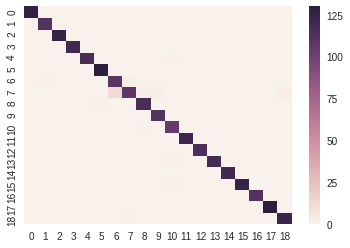

In [15]:
y_pred = rf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
sn.heatmap(conf_mat)

In [ ]:
distances=(X_test**2).sum(axis=1,keepdims=True)+(X_train**2).sum(axis=1)-2*np.dot(X_test,X_train.T)

ty=np.zeros(y_test.shape)
for i in xrange(X_test.shape[0]):
    temp=np.argsort(distances[i,:])
    l=y_train[temp[:10]]
    ty[i]=Counter(l).most_common()[0][0]
    

print sum(y_test==ty)*1.0/y_test.shape[0]    

### EFFIECIENCIES FOR SINGLE ACCELEROMETER AND FOUR ACCELEROMETERS 

In [ ]:
def the_split(z):
    #Method to split the data into 4,3,2,1 accelerometers
    r=np.arange(0,z.shape[1]+1,3)
    m=[]
    for i in xrange(len(r)):
        temp=[]
        start=True
        for j in xrange(len(r)):
            if i!=j and start:
                temp=z[:,r[j]:r[j+1]]
                start=False
            elif (not start) and i!=j and j+1<len(r):
                temp=np.hstack((temp,z[:,r[j]:r[j+1]]))
        temp=np.array(temp)
        if temp.shape[-1]!=r[-1]:
            m.append(temp)
    return np.array(m)

In [ ]:
z = the_split(a[0])
acc0 = z[0]
acc1 = z[1]
acc2 = z[2]
acc3 = z[3]
acc4 = z[4]

for i in xrange(1,9120):
    t1=time()
    z=the_split(a[i])
    acc0 = np.dstack((acc0,z[0]))
    acc1 = np.dstack((acc1,z[1]))
    acc2 = np.dstack((acc2,z[2]))
    acc3 = np.dstack((acc3,z[3]))
    acc4 = np.dstack((acc4,z[4]))
    print i,time()-t1


In [ ]:
acc0.shape

In [ ]:
def eff(feat):
    X_train, X_test, y_t, y_test = model_selection.train_test_split(feat, y_train, test_size=0.25, random_state=0)
    rf=RandomForestClassifier(n_estimators=num_est,criterion='entropy')
    rf.fit(X_train,y_t)
    print rf.score(X_test,y_test)
    y_pred = rf.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    print rf.feature_importances_
    sn.heatmap(conf_mat)

def extract_fs(v,flag):
    fsl = []
    fsl = np.array(fsl)
    if(flag == 5):
        fsl = get_features(v[:,:,0])
        n = v.shape[2]
    elif(flag == 1):
        fsl = get_features(v[0,:,:])
        n = v.shape[0]
    for i in xrange(1,n):
        if(flag == 5):
            z1=get_features(v[:,:,i])
        elif(flag == 1):
            z1=get_features(v[i,:,:])
        fsl = np.vstack((fsl,z1))
    return fsl 


In [ ]:
acc_0 = extract_fs(acc0,5)
acc_1 = extract_fs(acc1,5)
acc_2 = extract_fs(acc2,5)
acc_3 = extract_fs(acc3,5)
acc_4 = extract_fs(acc4,5)

In [ ]:
eff(acc_0)

In [ ]:
eff(acc_1)

In [ ]:
eff(acc_2)

In [ ]:
eff(acc_3)

In [ ]:
eff(acc_4)

In [ ]:
single_acc0 = a[:,:,0:3]
single_acc1 = a[:,:,3:6]
single_acc2 = a[:,:,6:9]
single_acc3 = a[:,:,9:12]
single_acc4 = a[:,:,12:15]

single_acc_0 = extract_fs(single_acc0,1)
single_acc_1 = extract_fs(single_acc1,1)
single_acc_2 = extract_fs(single_acc2,1)
single_acc_3 = extract_fs(single_acc3,1)
single_acc_4 = extract_fs(single_acc4,1)
print single_acc_0.shape

In [ ]:
eff(single_acc_0)

In [ ]:
eff(single_acc_1)

In [ ]:
eff(single_acc_2)

In [ ]:
eff(single_acc_3)

In [ ]:
eff(single_acc_4)

# Architecture of the Neural Net :        #
--------------------------------------------------
* Input dims : n x 15                     
* Layer 1 : 15 x 100                         
* Layer 2 : 100 x 200                    
* Layer 3 : 200 x 19 (with softmax loss)  

In [ ]:
import tensorflow as tf
from keras.utils import to_categorical

num_features=21 #Change for each of things, put it in a loop
num_activities=19 #For daily sports and activities

x=tf.placeholder(tf.float32,shape=[None,num_features])
y=tf.placeholder(tf.float32,shape=[None,num_activities])

w1=tf.Variable(tf.random_uniform(shape=(num_features,100)))
b1=tf.Variable(tf.zeros(shape=(100,)))
w2=tf.Variable(tf.random_uniform(shape=(100,200)))
b2=tf.Variable(tf.zeros(shape=(200,)))
w3=tf.Variable(tf.random_uniform(shape=(200,19)))
b3=tf.Variable(tf.zeros(shape=(19,)))

h1=tf.add(tf.matmul(x,w1),b1)
h1_act=tf.nn.sigmoid(h1)
h2=tf.add(tf.matmul(h1_act,w2),b2)
h2_act=tf.nn.sigmoid(h2)
out=tf.add(tf.matmul(h2_act,w3),b3)



cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out,labels=y_t_1))
opzr=tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
init=tf.global_variables_initializer()
for X_train in [single_acc_0,single_acc_1,single_acc_2,single_acc_3,single_acc_4]:
    X_train, X_test, y_t, y_test = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=0)
    y_t_1,y_test_1=to_categorical(y_t),to_categorical(y_test)
    y_t_1=y_t_1[:,1:]
    y_test_1=y_test_1[:,1:]
    with tf.Session() as sess:
        sess.run(init)
        for epochs in xrange(600):
            _,c=sess.run([opzr,cost],feed_dict={x: X_train, y:y_t_1})
            if epochs%100==0:
                print "Epoch no : "+str(epochs) + "; Loss : "+str(c) 
        res=tf.equal(tf.argmax(out,1),tf.argmax(y_test_1,1))
        accuracy = tf.reduce_mean(tf.cast(res, "float"))
        print "Accuracy is :  ",accuracy.eval({x:X_test,y:y_test_1})


In [3]:
def efficiency(feats):
    num_est=5
    columns_list=["Mean x","Mean y","Mean z",
              "Dev x","Dev y","Dev z",
              "Corr x-y","Corr x-z","Corr y-z",
              "Min x","Min y","Min z",
             "Max x","Max y","Max z",
             "Skew x","Skew y","Skew z",
             "Kurtosis x", "Kurtosis y","Kurtosis z"]

    print "For Random Forest:"
    X_train, X_test, y_t, y_test = model_selection.train_test_split(feats, y_train, test_size=0.25, random_state=0)
    rf=RandomForestClassifier(n_estimators=100,max_features=6,criterion='entropy')
    rf.fit(X_train,y_t)
    
    t1=time()
    print rf.score(X_test,y_test)
    print "Time Taken : " + str(time()-t1)
    
    y_pred = rf.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    importances=rf.feature_importances_
    idx=np.argsort(importances)
    for _n_ in np.array(columns_list)[idx]:
        print _n_,
    print
    sn.heatmap(conf_mat)
    
    print "For Decision Trees:"
    d_tree=tree.DecisionTreeClassifier()
    d_tree.fit(X_train,y_t)
    t1=time()
    print d_tree.score(X_test,y_test)
    print "Time Taken : " + str(time()-t1)
    print
    
    print "For SVM:"
    clf=svm.SVC()
    clf.fit(X_train,y_t)
    
    t1=time()
    print clf.score(X_test,y_test)
    print "Time Taken : " + str(time()-t1)
    print
    
    print "For XGboost:"
    xg=xgboost.XGBClassifier(n_estimators=num_est)
    xg.fit(X_train,y_t)

    t1=time()
    print xg.score(X_test,y_test)
    print "Time Taken : " + str(time()-t1)
    print
    
    print "For Naive bayes:"
    gnb=GaussianNB()
    gnb.fit(X_train,y_t)
    t1=time()
    print gnb.score(X_test,y_test)
    print "Time Taken : " + str(time()-t1)
    print 

    print "For GMM:"
    gmm_=GaussianMixture()
    gmm_.fit(X_train,y_t)
    t1=time()
    res_gmm=gmm_.predict(X_test)
    t2=time()
    print res_gmm,y_test
    print(sum(res_gmm==y_test)*1.0/len(res_gmm))
    print "Time Taken : " + str(t2-t1)
    
    print 

    print "For Gaussian Mixture Model:"
    n_classes = len(np.unique(y_t))
    print n_classes
    for j in ['full','spherical','diag','tied']:
        gmm=mixture.BayesianGaussianMixture( n_components=19,covariance_type=j,max_iter=1000)
        gmm.fit(X_train)
        gmm_y_train=gmm.predict(X_train)
        gmm_train_accuracy=np.mean(gmm_y_train.ravel() == y_t.ravel())
        print gmm_y_train.ravel()
        print y_t.ravel()
        print "Using",j,"as the covariance type,the efficiency: ",gmm_train_accuracy
    print 
    print "For Adaboost:"
    ada=AdaBoostClassifier(n_estimators=100,learning_rate=0.001)
    ada.fit(X_train,y_t)
    t1=time()
    print ada.score(X_test,y_test)
    print "Time Taken : " + str(time()-t1)
    print 
    
    print "For ANN:"
    clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,200,19),random_state=1,max_iter=600)
    clf.fit(X_train,y_t)
    t1=time()
    print clf.score(X_test,y_test)
    print "Time Taken : " + str(time()-t1)

For Random Forest:
0.914912280702
Time Taken : 0.00691294670105
Skew y
Corr x-y
Corr y-z
Kurtosis z
Skew z
Kurtosis y
Mean y
Mean z
Max z
Min y
Skew x
Max y
Kurtosis x
Corr x-z
Min z
Min x
Mean x
Dev y
Dev z
Dev x
Max x

For Decision Trees:
0.866228070175
Time Taken : 0.00278806686401

For SVM:
0.88201754386
Time Taken : 0.721133947372

For XGboost:
0.795614035088
Time Taken : 0.00912404060364

For Naive bayes:
0.695614035088
Time Taken : 0.0114629268646

For GMM:
[0 0 0 ..., 0 0 0] [15 10 15 ..., 19 11  9]
0.0
Time Taken : 0.00112509727478

For Gaussian Mixture Model:
19
[15  0 12 ...,  6 10  0]
[ 8 11 19 ..., 11  7  6]
Using full as the covariance type,the efficiency:  0.0362573099415
[12 10  5 ..., 10 11  9]
[ 8 11 19 ..., 11  7  6]
Using spherical as the covariance type,the efficiency:  0.0533625730994
[16  6  2 ...,  1  7 14]
[ 8 11 19 ..., 11  7  6]
Using diag as the covariance type,the efficiency:  0.123538011696
[7 1 4 ..., 1 1 1]
[ 8 11 19 ..., 11  7  6]
Using tied as the cova

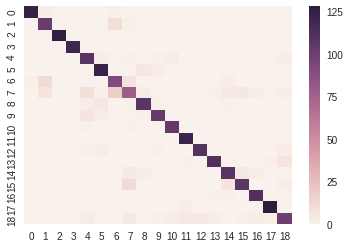

In [32]:
efficiency(a0)

For Random Forest:
0.902631578947
Time Taken : 0.00789189338684
Skew z
Kurtosis z
Kurtosis y
Skew y
Kurtosis x
Corr y-z
Max y
Corr x-z
Skew x
Max z
Mean z
Mean y
Min y
Mean x
Corr x-y
Dev y
Dev z
Min z
Dev x
Min x
Max x

For Decision Trees:
0.852631578947
Time Taken : 0.00116801261902

For SVM:
0.848684210526
Time Taken : 0.787402153015

For XGboost:
0.801315789474
Time Taken : 0.00831699371338

For Naive bayes:
0.597807017544
Time Taken : 0.0119879245758

For GMM:
[0 0 0 ..., 0 0 0] [15 10 15 ..., 19 11  9]
0.0
Time Taken : 0.00097393989563

For Gaussian Mixture Model:
19
[ 2  3 10 ...,  2 11 17]
[ 8 11 19 ..., 11  7  6]
Using full as the covariance type,the efficiency:  0.0264619883041
[12  0  5 ...,  3 18 11]
[ 8 11 19 ..., 11  7  6]
Using spherical as the covariance type,the efficiency:  0.0619883040936
[16 12  8 ..., 14  0 17]
[ 8 11 19 ..., 11  7  6]
Using diag as the covariance type,the efficiency:  0.0416666666667
[1 3 2 ..., 6 3 3]
[ 8 11 19 ..., 11  7  6]
Using tied as the co

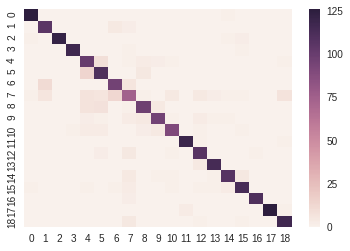

In [33]:
efficiency(a1)

For Random Forest:
0.906578947368
Time Taken : 0.00716400146484
Skew z
Kurtosis y
Skew y
Kurtosis z
Skew x
Corr y-z
Max z
Kurtosis x
Corr x-z
Corr x-y
Min y
Mean y
Max y
Mean z
Min z
Min x
Max x
Dev z
Dev y
Dev x
Mean x

For Decision Trees:
0.875
Time Taken : 0.0011670589447

For SVM:
0.848684210526
Time Taken : 0.714316129684

For XGboost:
0.814473684211
Time Taken : 0.0124258995056

For Naive bayes:
0.678947368421
Time Taken : 0.0130891799927

For GMM:
[0 0 0 ..., 0 0 0] [15 10 15 ..., 19 11  9]
0.0
Time Taken : 0.000920057296753

For Gaussian Mixture Model:
19
[ 8  0 16 ...,  7 17  0]
[ 8 11 19 ..., 11  7  6]
Using full as the covariance type,the efficiency:  0.0280701754386
[12 12  2 ...,  7  3  1]
[ 8 11 19 ..., 11  7  6]
Using spherical as the covariance type,the efficiency:  0.00511695906433
[10  0 18 ...,  9 15  7]
[ 8 11 19 ..., 11  7  6]
Using diag as the covariance type,the efficiency:  0.015350877193
[ 0 15 12 ..., 10 15 15]
[ 8 11 19 ..., 11  7  6]
Using tied as the covari

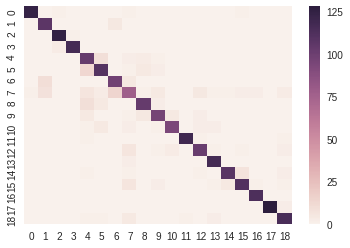

In [34]:
efficiency(a2)

For Random Forest:
0.930263157895
Time Taken : 0.00693011283875
Skew z
Corr y-z
Kurtosis z
Max z
Corr x-z
Min z
Kurtosis x
Mean z
Skew y
Kurtosis y
Max y
Corr x-y
Skew x
Min y
Dev y
Mean y
Dev z
Mean x
Min x
Max x
Dev x

For Decision Trees:
0.900877192982
Time Taken : 0.00111317634583

For SVM:
0.854824561404
Time Taken : 0.716407060623

For XGboost:
0.853947368421
Time Taken : 0.0105900764465

For Naive bayes:
0.802192982456
Time Taken : 0.0117239952087

For GMM:
[0 0 0 ..., 0 0 0] [15 10 15 ..., 19 11  9]
0.0
Time Taken : 0.000872850418091

For Gaussian Mixture Model:
19
[ 2  4 17 ...,  7 11 12]
[ 8 11 19 ..., 11  7  6]
Using full as the covariance type,the efficiency:  0.000438596491228
[ 6  2 15 ...,  1 10  2]
[ 8 11 19 ..., 11  7  6]
Using spherical as the covariance type,the efficiency:  0.0226608187135
[ 3 14  5 ...,  8 15  3]
[ 8 11 19 ..., 11  7  6]
Using diag as the covariance type,the efficiency:  0.0149122807018
[ 9  0  4 ...,  9 12  0]
[ 8 11 19 ..., 11  7  6]
Using tied a

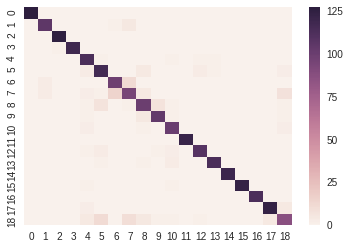

In [35]:
efficiency(a3)

For Random Forest:
0.932894736842
Time Taken : 0.00811505317688
Skew z
Corr y-z
Corr x-y
Kurtosis z
Corr x-z
Kurtosis y
Max z
Skew y
Mean z
Skew x
Dev z
Min y
Max y
Kurtosis x
Min z
Max x
Min x
Dev x
Mean x
Mean y
Dev y

For Decision Trees:
0.908333333333
Time Taken : 0.00132489204407

For SVM:
0.867543859649
Time Taken : 0.714118003845

For XGboost:
0.863596491228
Time Taken : 0.0112340450287

For Naive bayes:
0.807894736842
Time Taken : 0.0113368034363

For GMM:
[0 0 0 ..., 0 0 0] [15 10 15 ..., 19 11  9]
0.0
Time Taken : 0.000949859619141

For Gaussian Mixture Model:
19
[16 15  9 ..., 14  8  9]
[ 8 11 19 ..., 11  7  6]
Using full as the covariance type,the efficiency:  0.0181286549708
[ 0  6 15 ..., 14  2 12]
[ 8 11 19 ..., 11  7  6]
Using spherical as the covariance type,the efficiency:  0.0466374269006
[15  0 18 ..., 10  4 17]
[ 8 11 19 ..., 11  7  6]
Using diag as the covariance type,the efficiency:  0.0195906432749
[ 3  3  0 ..., 12  5  3]
[ 8 11 19 ..., 11  7  6]
Using tied as 

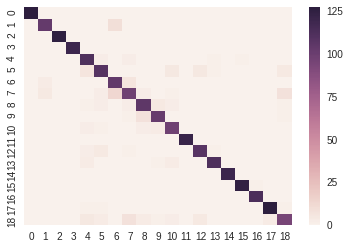

In [36]:
efficiency(a4)

In [10]:
print "For Random Forest:"
#print fs.shape
y_train=[]
for labels in xrange(1,20):
    for _ in xrange(480):
        y_train.append(labels)
y_train=np.array(y_train)
print y_train.shape

columns_list=["Mean x","Mean y","Mean z",
              "Dev x","Dev y","Dev z",
              "Corr x-y","Corr x-z","Corr y-z",
              "Min x","Min y","Min z",
             "Max x","Max y","Max z",
             "Skew x","Skew y","Skew z",
             "Kurtosis x", "Kurtosis y","Kurtosis z"]

for feats in [a0,a1,a2,a3,a4]:
    X_train, X_test, y_t, y_test = model_selection.train_test_split(feats, y_train, test_size=0.25, random_state=42,stratify=y_train)
    rf=RandomForestClassifier(n_estimators=100,max_features=6,criterion='entropy')
    rf.fit(X_train,y_t)
    y_pred = rf.predict(X_test)
    importances=rf.feature_importances_
    idx=np.argsort(importances)
    cl=np.array(columns_list)[idx]
    importances=importances[idx]
    z=np.vstack((cl,importances))
    for _n_ in z.T:
        print _n_[0],_n_[1]
    print rf.score(X_test,y_test)
    

For Random Forest:
(9120,)
Skew y 0.00504538806431
Corr y-z 0.00648907456513
Corr x-y 0.0107237035875
Kurtosis z 0.0114068598604
Skew z 0.0143217290117
Kurtosis y 0.0159146480111
Min y 0.0284198273324
Max z 0.0290412799894
Mean y 0.0290972933748
Skew x 0.0305998769438
Kurtosis x 0.0351847601077
Mean z 0.0376912292948
Max y 0.0409814431166
Corr x-z 0.0426179072522
Min z 0.0504952718177
Mean x 0.0524473567436
Min x 0.0742316704776
Dev y 0.0867319967333
Dev z 0.0985478145104
Max x 0.146815537484
Dev x 0.153195331721
0.950438596491
Skew z 0.00553747798193
Kurtosis z 0.00753836572024
Skew y 0.00851263741961
Corr y-z 0.0154115933823
Kurtosis y 0.0165914645975
Kurtosis x 0.0207546848018
Skew x 0.0237020959714
Max z 0.025670597312
Corr x-z 0.0267813328156
Min z 0.0296080007349
Min y 0.0315255489832
Max y 0.03272616112
Mean z 0.0388807366879
Corr x-y 0.0407098369658
Mean y 0.0453424670946
Mean x 0.0819336682713
Dev z 0.0830016644397
Min x 0.0836060206156
Dev y 0.0994302326113
Max x 0.1053138056

In [12]:
print "For Extra Trees:"
for feats in [a0,a1,a2,a3,a4]:
    X_train, X_test, y_t, y_test = model_selection.train_test_split(feats, y_train, test_size=0.25, random_state=42)
    rf=ExtraTreesClassifier(n_estimators=100,max_features=6,criterion='entropy')
    rf.fit(X_train,y_t)
    y_pred = rf.predict(X_test)
    importances=rf.feature_importances_
    idx=np.argsort(importances)
    cl=np.array(columns_list)[idx]
    importances=importances[idx]
    z=np.vstack((cl,importances))
    for _n_ in z.T:
        print _n_[0],_n_[1]
    print rf.score(X_test,y_test)
    

For Extra Trees:
Skew y 0.00773267370367
Corr y-z 0.0123441365507
Kurtosis z 0.0124308297206
Kurtosis y 0.0126822952453
Corr x-y 0.0150027794814
Skew z 0.0166511077693
Kurtosis x 0.0223190023572
Max z 0.0314682062152
Min y 0.0328630535338
Skew x 0.0335670003367
Mean y 0.0406632623474
Max y 0.0436797646004
Mean z 0.0489973648815
Min z 0.0504864349034
Corr x-z 0.0639034719728
Mean x 0.071364482536
Min x 0.0778080242011
Dev z 0.0817346954174
Max x 0.0866110337112
Dev y 0.0995909472349
Dev x 0.13809943328
0.964473684211
Skew z 0.0071373842172
Kurtosis z 0.00771725090283
Skew y 0.00944484115349
Kurtosis y 0.00983157882185
Kurtosis x 0.0123493679282
Skew x 0.019629722644
Corr y-z 0.0259009705651
Corr x-z 0.0340767535054
Max z 0.0363533299921
Min y 0.0445885842184
Min z 0.0489823079813
Max y 0.0492264908185
Mean y 0.0532751131734
Mean z 0.06143341838
Corr x-y 0.0620438075098
Min x 0.0670527240114
Dev z 0.0736776188562
Max x 0.0783290113509
Dev y 0.0850939471067
Mean x 0.0954367586978
Dev x 0.